# 概要

Character-LevelのCNNでWAFを作る。  
論文の内容をKerasで実装してみる。  
原著論文はこちら http://iyatomi-lab.info/sites/default/files/user/CSPA2018%20Proceedings_ito.pdf 


In [ ]:
!apt install neofetch
!neofetch

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  neofetch
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 74.8 kB of archives.
After this operation, 365 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 neofetch all 3.4.0-1 [74.8 kB]
Fetched 74.8 kB in 1s (103 kB/s)
Selecting previously unselected package neofetch.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../neofetch_3.4.0-1_all.deb ...
Unpacking neofetch (3.4.0-1) ...
Setting up neofetch (3.4.0-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
            .-/+oossssoo+/-. 
        `:+ssssssssssssssssss+:` 
      -+ssssssssssssssssssyyssss+- 
    .ossssssssssssssssssdMMMNysssso. 
   /ssssssssssshdmmNNmmyNMMMMhssssss/ 
  +ssssssssshmydMMMMMMMNddddyssssssss+ 
 /sssssssshNMMMyhhyyyyhmNMMMNhssssssss/ 
.s

## データの準備

inputはURL decode -> Unicode encodeしたもの

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Embedding, Dense, Dropout, Flatten, Conv1D, MaxPool1D, Add, Reshape, normalization, Concatenate, merge, GlobalMaxPooling1D
from keras.utils import plot_model, to_categorical, np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras import optimizers

In [ ]:
pd.set_option("display.max_colwidth", 1024)

In [ ]:
%cd /content/drive/MyDrive/WAffle/
!ls -al

/content/drive/MyDrive/WAffle
total 155409
-rw------- 1 root root    287003 Jan 24 19:22 1D-conv
-rw------- 1 root root     82093 Jan 24 11:39 2D-conv
-rw------- 1 root root    253482 Jan 15 20:15 CharacterLevel-CNN
drwx------ 2 root root      4096 Dec 27 18:45 Dataset
-rw------- 1 root root     23042 Jan 24 12:39 example
drwx------ 2 root root      4096 Jan 16 02:19 images
drwx------ 2 root root      4096 Dec 27 13:42 KerasPractice
drwx------ 2 root root      4096 Jan  9 05:29 log
drwx------ 2 root root      4096 Dec 30 12:35 model_dir
-rw------- 1 root root 104236608 Jan 20 18:29 model.h5
-rw------- 1 root root  26683198 Jan  9 05:29 ngrok
-rw------- 1 root root  13773305 Jan  9 05:27 ngrok-stable-linux-amd64.zip
-rw------- 1 root root  13773305 Jan  9 05:28 ngrok-stable-linux-amd64.zip.1
drwx------ 2 root root      4096 Jan 16 02:19 slides


In [ ]:
df = pd.read_csv('Dataset/cisc_database/csic_database.csv')

In [ ]:
df = df.rename(columns={'Unnamed: 0':'Target'})

In [ ]:
df.head()

,Target,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
0,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko),no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko),no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.jsp?id=3&nombre=Vino+Rioja&precio=100&cantidad=55&B1=A%F1adir+al+carrito HTTP/1.1
2,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko),no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&B1=A%F1adir+al+carrito,0,http://localhost:8080/tienda1/publico/anadir.jsp HTTP/1.1
3,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko),no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autenticar.jsp?modo=entrar&login=choong&pwd=d1se3ci%F3n&remember=off&B1=Entrar HTTP/1.1
4,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko),no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remember=off&B1=Entrar,0,http://localhost:8080/tienda1/publico/autenticar.jsp HTTP/1.1


### 前処理

目標: 'Target', 'URL'のみのDataFrameにする。
DataFrameをtrain, testに8:2で分割し、URLをInput、Targetをlabelとなるようにしていく。

In [ ]:
df = df[['Target', 'URL']]
df.tail()

,Target,URL
61060,Anomalous,http://localhost:8080/tienda1/miembros/editar.jsp?modo=registro&login=beaumont&password=quEratItiS&nombre=Odilia&apellidos=Stumptner&email=henried%40cbgerindote.asia&dniA=66631393W&direccion=C%2F+Xoana+Nogueira%2C+25+5%3FC&ciudad=Barrios%2C+Los&cp=46135&provincia=%C1vila&ntc=2498947451884473&B1=Registrar HTTP/1.1
61061,Anomalous,http://localhost:8080/tienda1/miembros/editar.jsp HTTP/1.1
61062,Anomalous,http://localhost:8080/tienda1/miembros/editar.jsp.bak HTTP/1.1
61063,Anomalous,http://localhost:8080/tienda1/imagenes/3.gif/ HTTP/1.1
61064,Anomalous,http://localhost:8080/tienda1/imagenes/nuestratierra.jpg.BAK HTTP/1.1


In [ ]:
# Targetカラムの変更。
# if (df['Target'] == Normal){0} else {1}

# Normalを0, それ以外は1に置換。lossにはbinary_crossentropyを使う。
df['Target'] = df['Target'].apply(lambda x:0 if str(x) == 'Normal' else 1)
df.head()

,Target,URL
0,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,0,http://localhost:8080/tienda1/publico/anadir.jsp?id=3&nombre=Vino+Rioja&precio=100&cantidad=55&B1=A%F1adir+al+carrito HTTP/1.1
2,0,http://localhost:8080/tienda1/publico/anadir.jsp HTTP/1.1
3,0,http://localhost:8080/tienda1/publico/autenticar.jsp?modo=entrar&login=choong&pwd=d1se3ci%F3n&remember=off&B1=Entrar HTTP/1.1
4,0,http://localhost:8080/tienda1/publico/autenticar.jsp HTTP/1.1


In [ ]:
# URLの末尾にあるHTTP 1.1という文字列を消す
df['URL'] = df['URL'].str[:-8]
df.head()

,Target,URL
0,0,http://localhost:8080/tienda1/index.jsp
1,0,http://localhost:8080/tienda1/publico/anadir.jsp?id=3&nombre=Vino+Rioja&precio=100&cantidad=55&B1=A%F1adir+al+carrito
2,0,http://localhost:8080/tienda1/publico/anadir.jsp
3,0,http://localhost:8080/tienda1/publico/autenticar.jsp?modo=entrar&login=choong&pwd=d1se3ci%F3n&remember=off&B1=Entrar
4,0,http://localhost:8080/tienda1/publico/autenticar.jsp


In [ ]:
# Train : Valid : Test = 6 : 2 : 2

X_train, X_val, y_train, y_val = train_test_split(df['URL'], df['Target'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)

print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)

print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (36639,)
y_train shape (36639,)
X_val shape (12213,)
y_val shape (12213,)
X_test shape (12213,)
y_test shape (12213,)


In [ ]:
# convert string to lower case
train_texts = X_train
train_texts = [s.lower() for s in train_texts]

val_texts = X_val
val_texts = [s.lower() for s in val_texts]

In [ ]:
# convert string to index
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1
string_size = len(alphabet)

In [ ]:
#いつか使う URL decode
import urllib.parse
def url_decode(encoded_URL):
  return urllib.parse.unquote(encoded_URL)

In [ ]:
# URL decode -> Unicode encode
def load_data(txt, max_length=1000):
    txt_list = []
    for l in txt:
        l = url_decode(l)
        txt_line = [ord(x) for x in str(l).strip()]
        txt_line = txt_line[:max_length]
        txt_len = len(txt_line)
        if txt_len < max_length:
            txt_line += ([0] * (max_length - txt_len))
        txt_list.append((txt_line))
    return txt_list

In [ ]:
train_data = load_data(train_texts)
val_data = load_data(val_texts)

In [ ]:
print("train_texts")
print(train_texts[0])

print("train_data")
print(train_data[0])

train_texts
http://localhost:8080/tienda1/publico/autenticar.jsp?modo=entrar&login=glazer&pwd=rustir&remember=on&b1=entrar 
train_data
[104, 116, 116, 112, 58, 47, 47, 108, 111, 99, 97, 108, 104, 111, 115, 116, 58, 56, 48, 56, 48, 47, 116, 105, 101, 110, 100, 97, 49, 47, 112, 117, 98, 108, 105, 99, 111, 47, 97, 117, 116, 101, 110, 116, 105, 99, 97, 114, 46, 106, 115, 112, 63, 109, 111, 100, 111, 61, 101, 110, 116, 114, 97, 114, 38, 108, 111, 103, 105, 110, 61, 103, 108, 97, 122, 101, 114, 38, 112, 119, 100, 61, 114, 117, 115, 116, 105, 114, 38, 114, 101, 109, 101, 109, 98, 101, 114, 61, 111, 110, 38, 98, 49, 61, 101, 110, 116, 114, 97, 114, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
print("val_texts")
print(val_texts[0])

print("val_data")
print(val_data[0])

val_texts
http://localhost:8080/tienda1/publico/caracteristicas.jsp?id=2 
val_data
[104, 116, 116, 112, 58, 47, 47, 108, 111, 99, 97, 108, 104, 111, 115, 116, 58, 56, 48, 56, 48, 47, 116, 105, 101, 110, 100, 97, 49, 47, 112, 117, 98, 108, 105, 99, 111, 47, 99, 97, 114, 97, 99, 116, 101, 114, 105, 115, 116, 105, 99, 97, 115, 46, 106, 115, 112, 63, 105, 100, 61, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# Convert to numpy array
train_data = np.array(train_data)
val_data = np.array(val_data)

In [ ]:
train_classes = y_train
train_class_list = [x for x in train_classes]

val_classes = y_val
val_class_list = [x  for x in val_classes]

In [ ]:
train_classes = np.array(train_class_list)
val_classes = np.array(val_class_list)

In [ ]:
print(train_classes)
print(val_classes)

[0 0 0 ... 1 1 1]
[0 0 1 ... 1 0 0]


## アーキテクチャ

1. Input(1000 characters)
2. Embedding(128demensions)
3. Conv(kernelsize = K, filter_num = 64) -> RELU
4. Max Pooling(kernelsize = K)
5. Conv(kernelsize = K, filter_num = 64) -> RELU
6. Max Pooling(kernel_size = size of Conv 5's output)
7. concat output & reshape into 256 length vector
8. FCN(64 units) -> RELU
9. Batch normalize
10. Dropout(0.5)
11. FCN(1 unit) -> Sigmoid

(categorical_crossentropy)

In [ ]:
# config
input_max_size = 1000
embedding_size = 128
conv_layers = 4
kernel_sizes = [4,5,6,7]
filter_num = 64
fully_connected_layers = [64,64]
num_of_classes = 1
dropout = 0.5
optimizer = 'adam'
loss = 'binary_crossentropy'

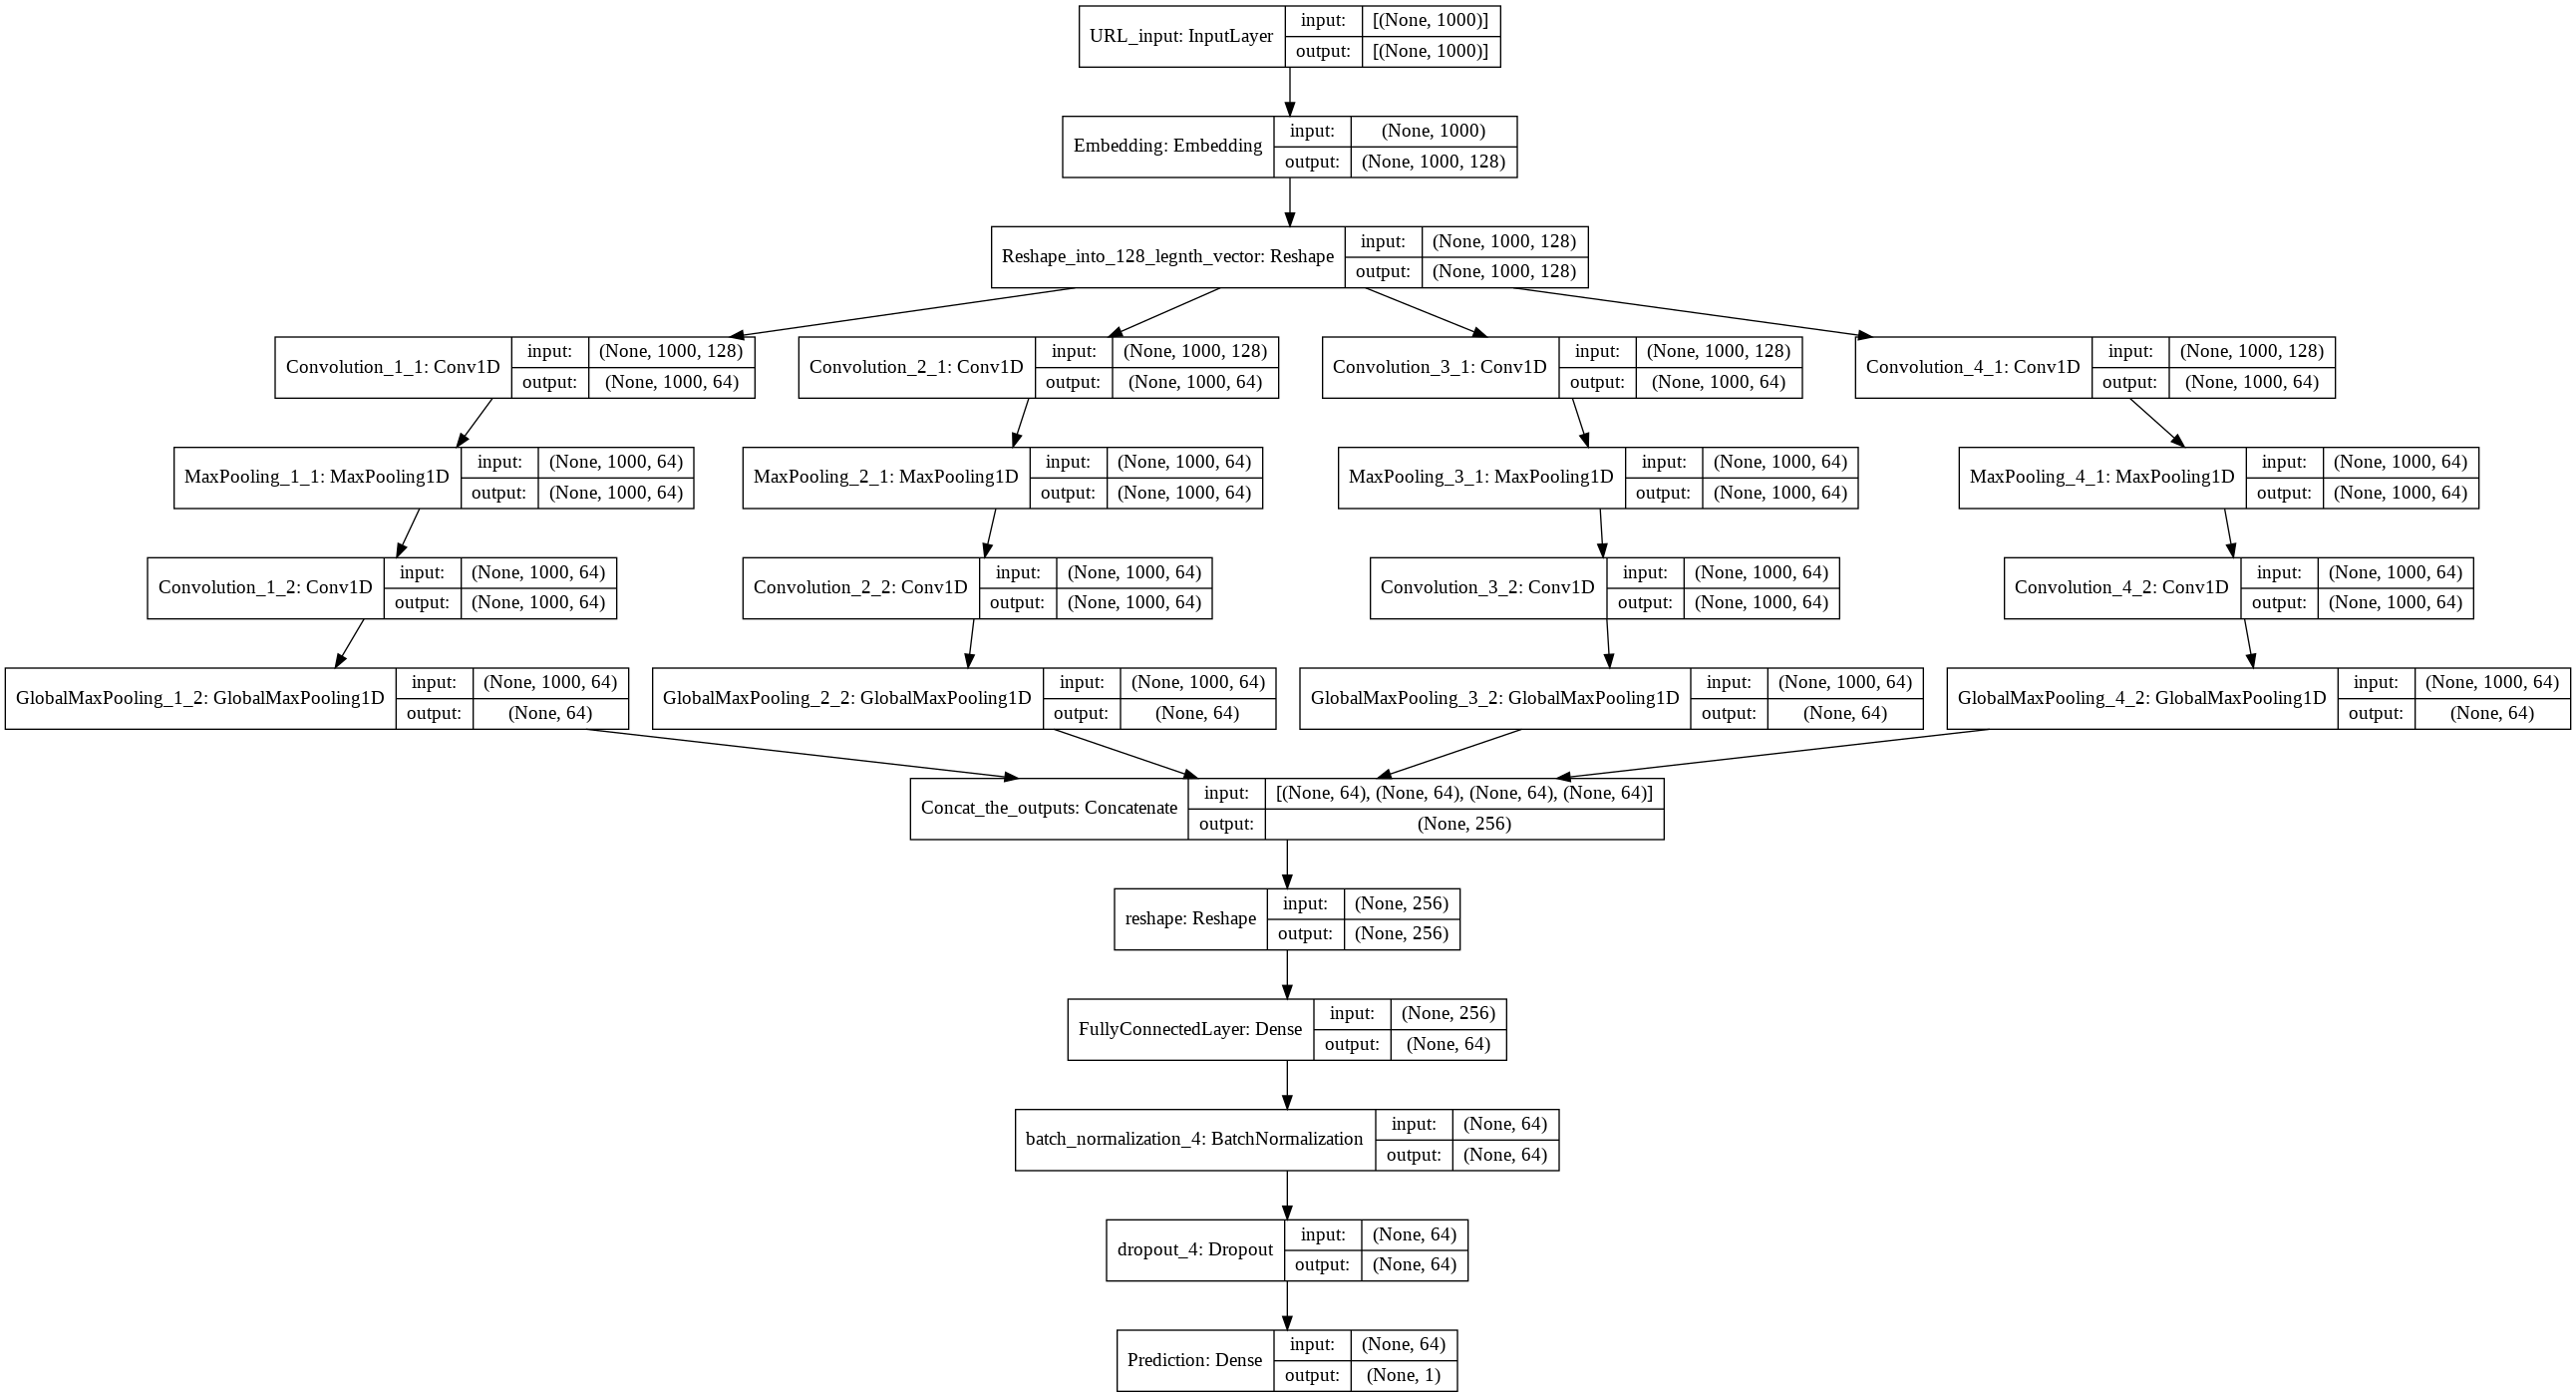

In [ ]:
# Input Layer
# URLdecodeされた文字列をInputとして与える。
inputs = Input(shape=(input_max_size,), name='URL_input')

# Embedding Layer
x = Embedding(0xffff, embedding_size, name='Embedding')(inputs)
x = Reshape((input_max_size, embedding_size), name='Reshape_into_128_legnth_vector')(x)

# Convolution Layers
convolution_output = []

conv1_1 = Conv1D(filter_num, 4, activation='relu', padding='same', strides=1, name='Convolution_1_1')(x)
pool1_1 = MaxPool1D(pool_size=4, padding='same', strides=1, name='MaxPooling_1_1')(conv1_1)
conv1_2 = Conv1D(filter_num, 4, activation='relu', padding='same', strides=1, name='Convolution_1_2')(pool1_1)
pool1_2 = GlobalMaxPooling1D(name='GlobalMaxPooling_1_2')(conv1_2)
convolution_output.append(pool1_2)

conv2_1 = Conv1D(filter_num,5, activation='relu', padding='same', strides=1, name='Convolution_2_1')(x)
pool2_1 = MaxPool1D(pool_size=5, padding='same', strides=1, name='MaxPooling_2_1')(conv2_1)
conv2_2 = Conv1D(filter_num, 5, activation='relu', padding='same', strides=1, name='Convolution_2_2')(pool2_1)
pool2_2 = GlobalMaxPooling1D(name='GlobalMaxPooling_2_2')(conv2_2)
convolution_output.append(pool2_2)

conv3_1 = Conv1D(filter_num, 6, activation='relu', padding='same', strides=1, name='Convolution_3_1')(x)
pool3_1 = MaxPool1D(pool_size=6, padding='same', strides=1, name='MaxPooling_3_1')(conv3_1)
conv3_2 = Conv1D(filter_num, 6, activation='relu', padding='same', strides=1, name='Convolution_3_2')(pool3_1)
pool3_2 = GlobalMaxPooling1D(name='GlobalMaxPooling_3_2')(conv3_2)
convolution_output.append(pool3_2)

conv4_1 = Conv1D(filter_num,7, activation='relu', padding='same', strides=1, name='Convolution_4_1')(x)
pool4_1 = MaxPool1D(pool_size=7, padding='same', strides=1, name='MaxPooling_4_1')(conv4_1)
conv4_2 = Conv1D(filter_num, 7, activation='relu', padding='same', strides=1, name='Convolution_4_2')(pool4_1)
pool4_2 = GlobalMaxPooling1D(name='GlobalMaxPooling_4_2')(conv4_2)
convolution_output.append(pool4_2)

# concat output
x = Concatenate(name='Concat_the_outputs')(convolution_output)

# reshape into 256 length vector
x = Reshape((256, ), name='reshape')(x)

# Fully Connected Layers
x = Dense(64, activation='relu', name='FullyConnectedLayer')(x)

# Batch Normalization
x = normalization.BatchNormalization()(x)

# DropOut
x = Dropout(dropout)(x)

# Fully Connected Layers
predictions = Dense(1, activation='sigmoid', name='Prediction')(x)

model = Model(inputs=inputs, outputs=predictions, name='Character-level_CNN')
plot_model(model, to_file='./images/1D-model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "Character-level_CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
URL_input (InputLayer)          [(None, 1000)]       0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 1000, 128)    8388480     URL_input[0][0]                  
__________________________________________________________________________________________________
Reshape_into_128_legnth_vector  (None, 1000, 128)    0           Embedding[0][0]                  
__________________________________________________________________________________________________
Convolution_1_1 (Conv1D)        (None, 1000, 64)     32832       Reshape_into_128_legnth_vector[0]
________________________________________________________________________________

In [ ]:
#Model = create_model(input_max_size, embedding_size, filter_num, fully_connected_layers)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
epochs = 100
batch_size = 128
# config
input_max_size = 1000
embedding_size = 128
conv_layers = 4
kernel_sizes = [4,5,6,7]
filter_num = 64
fully_connected_layers = [64,64]
num_of_classes = 1
dropout = 0.5
optimizer = 'adam'
loss = 'binary_crossentropy'

In [ ]:
def train(train_data, train_classes, val_data, val_classes, model, batch_size=64, epoch_count=200, max_length=1000, model_filepath="model_dir/1Dconv.h5", learning_rate=0.001):

    # 学習率を少しずつ下げるようにする
    start = learning_rate
    stop = learning_rate * 0.01
    learning_rates = np.linspace(start, stop, epoch_count)

    # モデル作成
    #model = create_model(max_length=max_length)
    model = model
    optimizer = optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # 学習
    model.fit(train_data, train_classes,
              epochs=epoch_count,
              batch_size=batch_size,
              verbose=2,
              validation_data=(val_data, val_classes),
              callbacks=[
                  tf.keras.callbacks.LearningRateScheduler(lambda epoch: learning_rates[epoch]),
              ])

    # モデルの保存
    model.save(model_filepath)

In [ ]:
train(train_data, train_classes, val_data, val_classes ,model)

Epoch 1/200
573/573 - 73s - loss: 0.2596 - accuracy: 0.8488 - val_loss: 0.3956 - val_accuracy: 0.8505
Epoch 2/200
573/573 - 71s - loss: 0.2512 - accuracy: 0.8519 - val_loss: 0.4628 - val_accuracy: 0.8160
Epoch 3/200
573/573 - 71s - loss: 0.2480 - accuracy: 0.8513 - val_loss: 0.2625 - val_accuracy: 0.8559
Epoch 4/200
573/573 - 71s - loss: 0.2437 - accuracy: 0.8552 - val_loss: 0.3301 - val_accuracy: 0.8217
Epoch 5/200
573/573 - 71s - loss: 0.2430 - accuracy: 0.8567 - val_loss: 0.2875 - val_accuracy: 0.8205
Epoch 6/200
573/573 - 71s - loss: 0.2440 - accuracy: 0.8548 - val_loss: 0.2755 - val_accuracy: 0.8202
Epoch 7/200
573/573 - 71s - loss: 0.2415 - accuracy: 0.8556 - val_loss: 0.4784 - val_accuracy: 0.8208
Epoch 8/200
573/573 - 71s - loss: 0.2387 - accuracy: 0.8556 - val_loss: 0.2842 - val_accuracy: 0.8223
Epoch 9/200
573/573 - 71s - loss: 0.2395 - accuracy: 0.8540 - val_loss: 0.4397 - val_accuracy: 0.8210
Epoch 10/200
573/573 - 71s - loss: 0.2361 - accuracy: 0.8556 - val_loss: 0.2876 - 

In [ ]:
model_filepath = 'model_dir/1Dconv'

model.save(model_filepath + '.h5')
model.save_weights(model_filepath + "_weight.h5")

In [ ]:
# ngrokのインストール
import os
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

# TensorBoardのlogフォルダ
LOG_DIR = './log'
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

# TensorBoardをバックグラウンドで実行
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR))

# ngrokバックグラウンドプロセスを起動
# TensorBoardのポート6006を開放します。
get_ipython().system_raw('./ngrok http 6006 &')

--2021-01-09 05:28:13--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.195.187.253, 54.159.34.239, 3.90.94.177, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.195.187.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  51.6MB/s    in 0.3s    

2021-01-09 05:28:13 (51.6 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ngrok                   


In [ ]:
# TensorBoard表示のURLを取得
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://b34c39cb02e1.ngrok.io


In [ ]:
model_filepath = 'model_dir/1Dconv'
model = load_model(model_filepath+'.h5')

In [ ]:
def text_encoding(input_url):
  input_url = url_decode(input_url)
  input_url = [ord(x) for x in str(input_url).strip()]
  input_url = input_url[:1000]
  if len(input_url) < 1000:
    input_url += ([0]*(1000-len(input_url)))
  #print(input_url)
  return input_url

In [ ]:
def predict(comments, model_filepath='model_dir/1Dconv.h5'):
  model = load_model(model_filepath)
  ret =model.predict(comments)
  return ret[0][0]

In [ ]:
model_file = "./model_dir/1Dconv_weight.h5"

In [ ]:
target = ['prediction']

In [ ]:
attack = []
attack.append('http://localhost:8080/get.php?input=<script>alert(1)</script>')
attack.append('http://localhost:8080/get.php?input=hoge')
attack.append('http://localhost:8080/tienda1/publico/registro.jsp?modo=registro&login=tejani&password=arable&nombre=Josiana&apellidos=De+Anta+Colondres&email=agunda-wulff%40onoratoinformatica.aq&dni=427%278643%27&direccion=C%2F+Jose+Zamoray%2C+S%2FN+4C&ciudad=Narros+del+Puerto&cp=23770&provincia=Tarragona&ntc=2400850921681991&B1=Registrar')
attack.append("http://localhost:8080/tienda1/publico/entrar.jsp")
attack.append("http://localhost:8080/tienda1/publico/autenticar.jsp?modo=entrar&login=whey-min&pwd=r.apaz&remember=on%2f&b1=entrar")
attack.append("http://www.example.com?userID=20%27%20or%20%271%27%3d%271")
attack.append('http://www.example.com/?userid=20+or+1=1;--')
attack.append('http://localhost:8080/?userid=20+or+1=1;--')
attack.append('<script>')
attack.append("SELECT")
attack.append("DELETE")
attack.append("DROP")
attack.append("WHERE")

In [ ]:
predict_results = []
for i in range(len(attack)):
  txt = text_encoding(attack[i])
  predict_results.append(predict(np.array([txt]))) 
predict_results

[0.9999882,
 0.9990224,
 0.9999974,
 0.5031214,
 0.9986699,
 0.99999976,
 0.9999958,
 0.99962246,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]